In [75]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import time
import json
import re

In [2]:
current_folder = Path.cwd()
tesi_folder = Path('~/Scuola/now').expanduser()

In [55]:
with open(tesi_folder / 'experiments.json', 'r') as reader:
    experiments = json.load(reader)

In [98]:
def plot_metrics(axis, train_metrics, eval_metrics, train_ylim=[0, 200], eval_ylim=[300, 600]):
    if train_metrics:
        done = len(train_metrics)
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(train_metrics) / 4.0, label='on TRAIN set (S1, S6, S7, S8)', color='red'
        )

        axis.set_ylim(train_ylim)
        axis.legend(loc='upper left')
    
    if eval_metrics:
        axis = axis.twinx()

        done = len(eval_metrics)
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(eval_metrics) / 2.0, label='on EVAL set (S9, S11)', color='green'
        )
        
        axis.set_ylim(eval_ylim)
        axis.legend(loc='upper right')

In [23]:
def get_figsize(n_rows, n_cols):
    row_size = 8  # heigth
    column_size = 24  # width

    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=get_figsize(n_rows, n_cols))
    return fig, ax

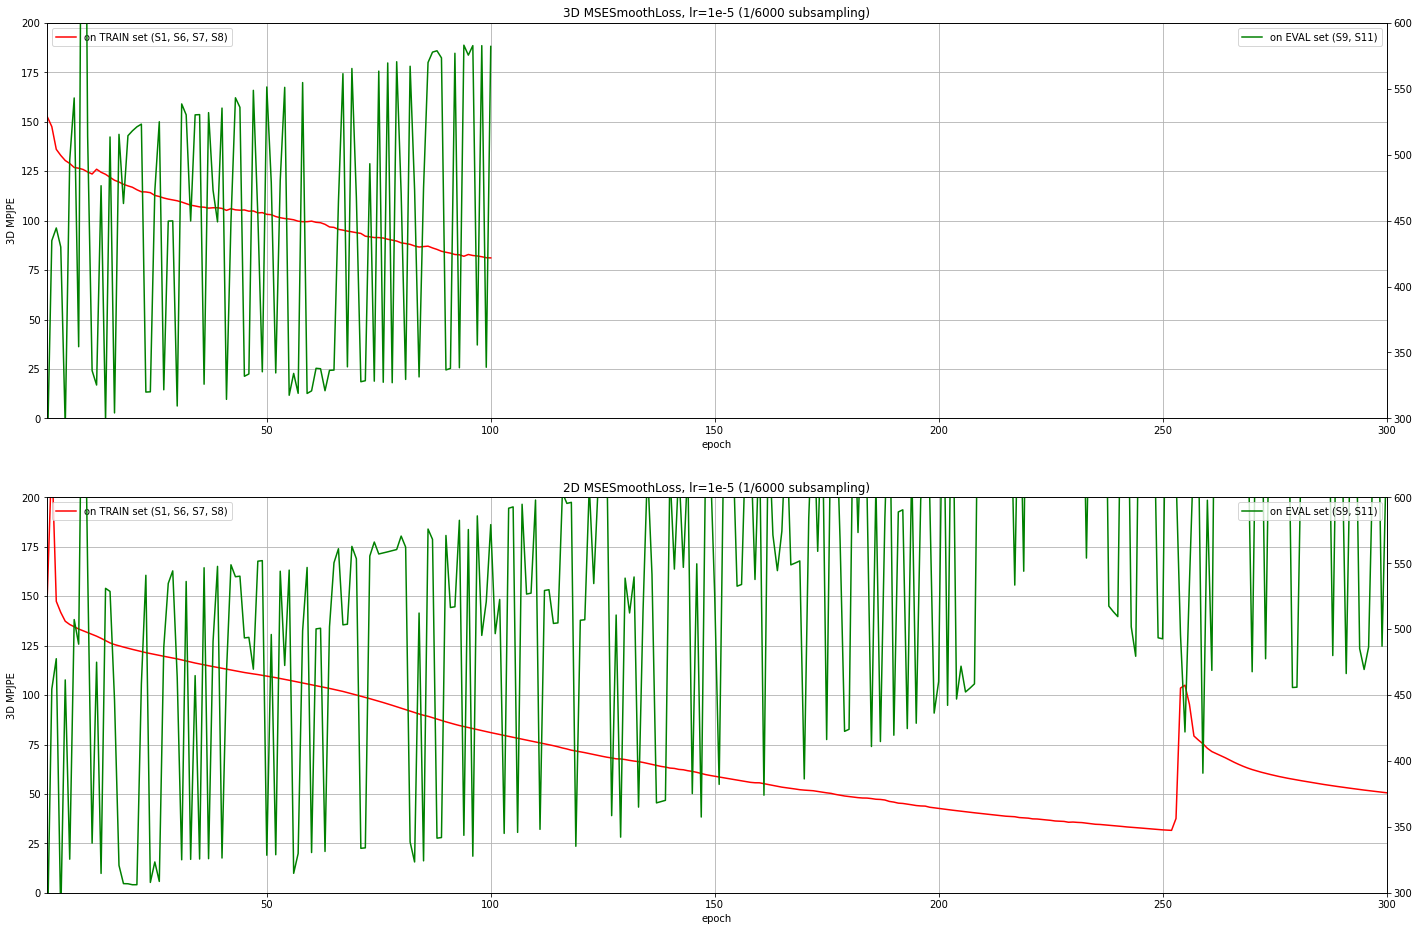

In [59]:
fig, ax = get_figa(2, 1)

for axis, metrics in zip(
        ax.ravel(),
        [experiments['04_08_13_09'], experiments['04_09_12_32']]
    ):

    train_metrics = metrics['train'] if 'train' in metrics else []
    eval_metrics = metrics['eval'] if 'eval' in metrics else []

    plot_metrics(axis, train_metrics, eval_metrics)

    axis.set_xlim([1, 300])

    axis.grid(True)
    axis.set_ylabel('3D MPJPE')
    axis.set_xlabel('epoch')
    
    axis.set_title(metrics['title'])

In [95]:
def parse_metrics_log(f_path):
    lines = []

    with open(f_path, 'r') as reader:
        lines = reader.readlines()
        lines = [
            line.strip()
            for line in lines
        ]
        
    split_index = lines.index('... on EVALuation set')
    training_stop_index = split_index - 1
    eval_start_index = split_index + 1
    
    is_fp_number = lambda x: not (re.match('\d.', x) is None)
    parse_fp_number = lambda x: float(x)
    
    train_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[:training_stop_index])
    )
    
    eval_metrics = map(
        parse_fp_number,
        filter(is_fp_number, lines[eval_start_index:])
    )
    
    return list(train_metrics), list(eval_metrics)

Text(0.5, 1.0, 'loss 3D, lr=1e-5, pretrained')

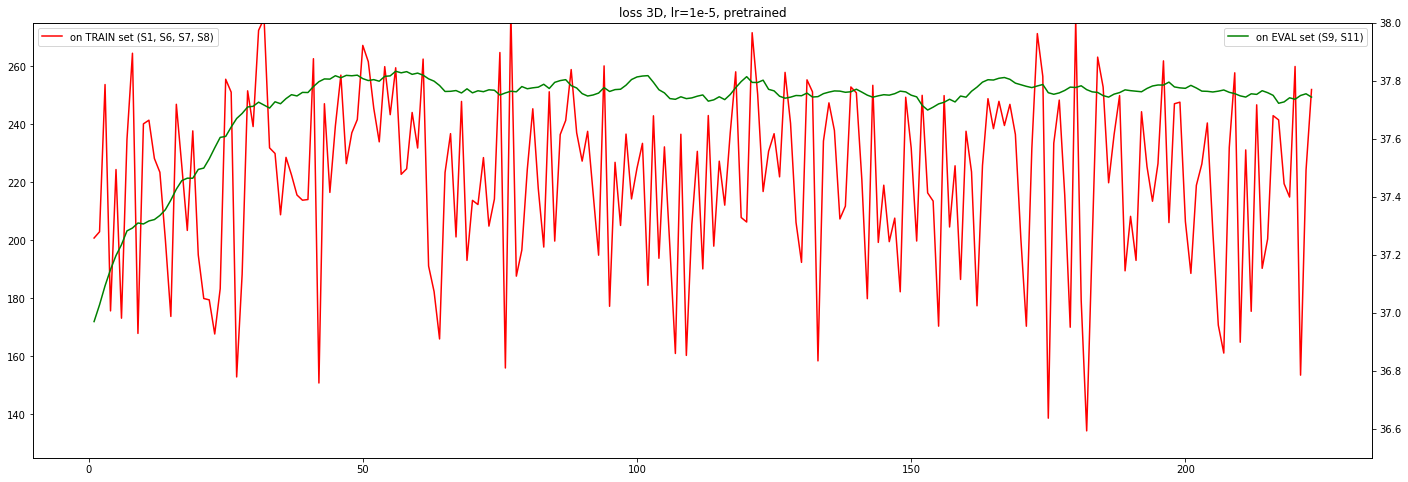

In [118]:
train_metrics, eval_metrics = parse_metrics_log(tesi_folder / '17_11.txt')

fig, ax = get_figa(1, 1)
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=[125, 275], eval_ylim=[36.5, 38])
ax.set_title('loss 3D, lr=1e-5, pretrained')

Text(0.5, 1.0, 'loss 3D, lr=1e-5')

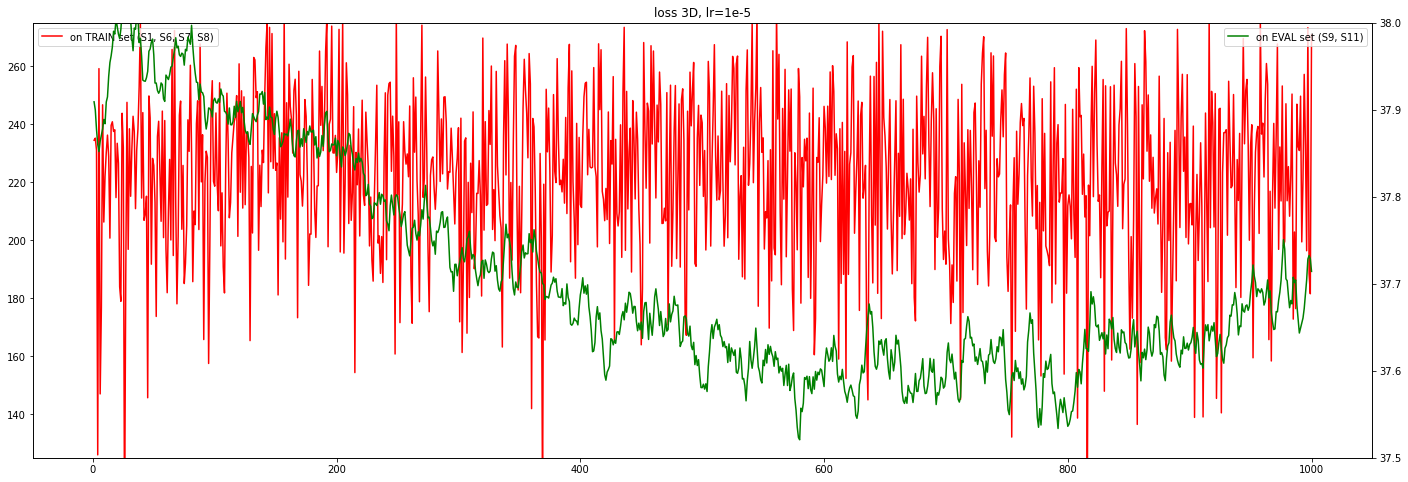

In [112]:
train_metrics, eval_metrics = parse_metrics_log(Path('~/Scuola/now/19_34.txt').expanduser())

fig, ax = get_figa(1, 1)
plot_metrics(ax, train_metrics, eval_metrics, train_ylim=[125, 275], eval_ylim=[37.5, 38])
ax.set_title('loss 3D, lr=1e-5')